In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import astropy.coordinates as coords
import astropy.time as at

import datetime
import time
import glob
import os.path as path
import sys

/ext3/miniconda3/envs/cnnenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /ext3/miniconda3/envs/cnnenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class DownSizeNet(nn.Module):
    def __init__(self, in_size, out_size, kernel_size = 3, stride=1, padding=1, leaky_slope=0.2):
        super(DownSizeNet, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size, stride=stride, padding=padding, bias=False).double()]
        layers.append(nn.MaxPool2d(3, stride=stride).double())
        layers.append(nn.LeakyReLU(leaky_slope).double())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        
        return self.model(x)
    
class ChunkNet(nn.Module):
    def __init__(self,s_in,s_h):
        super(ChunkNet, self).__init__()
        self.dense1 = nn.Sequential(nn.Linear(s_in,s_h), nn.ReLU()).double()
        
        self.final = nn.Linear(s_h,1).double()
        
    def forward(self,x):
        d1 = self.dense1(x)
        
        return self.final(d1)

    
class FeatureNet(nn.Module):
    def __init__(self):
        super(FeatureNet, self).__init__()
        self.down1 = DownSizeNet(3,   64,  stride=1)
        self.down2 = DownSizeNet(64,  64,  stride=1, padding=0)
        self.down3 = DownSizeNet(64,  128, stride=1, padding=0, kernel_size=5)
        self.down4 = DownSizeNet(128, 256, stride=2, padding=0, kernel_size=5)
        self.down5 = DownSizeNet(256, 256, stride=2, padding=0, kernel_size=5)
        
        
    def forward(self, x):
        # Propogate noise through fc layer and reshape to img shape
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
#         d6 = self.down6(d5)
        
        return d5
    
class RV_Model(nn.Module):
    def __init__(self,s_c,s_in,s_h,device):
        super(RV_Model, self).__init__()
        self.device = device
        
        self.chunk_models = nn.ModuleList([ChunkNet(s_in,s_h).double().to(device) for i in range(s_c)]).to(device)
        self.feature_model = FeatureNet().double().to(device)
        
    def forward(self,x,indices):
        y1 = self.feature_model(x)
        y1 = torch.flatten(y1,1)
        y2 = torch.empty((y1.shape[0])).to(self.device).double()
        # instead of looping through all indices passed
        # only loop through unique ones so that chunk models
        # can be batch-ran
        for i,index in enumerate(np.unique(indices).astype(int)):
            
#             temp = int()
#             print(y1.index_select(0,torch.where(indices==index)[0].to(self.device)))
#             print(torch.where(indices==index)[0])
#             print(y2.shape)
            y2[torch.where(indices==index)[0]] = self.chunk_models[index.item()](y1.index_select(0,torch.where(indices==index)[0].to(self.device))).squeeze()
            
        return y2

In [3]:
tlname = '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28-2/51Peg_720-976_1200-1456_multi_tl_bcs.nda.npy'
vlname = '/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/2023-02-28-2/51Peg_720-976_1200-1456_multi_vl_bcs.nda.npy'
train_loss= np.load(tlname)
valid_loss= np.load(vlname)

In [4]:
# tl_loss.shape

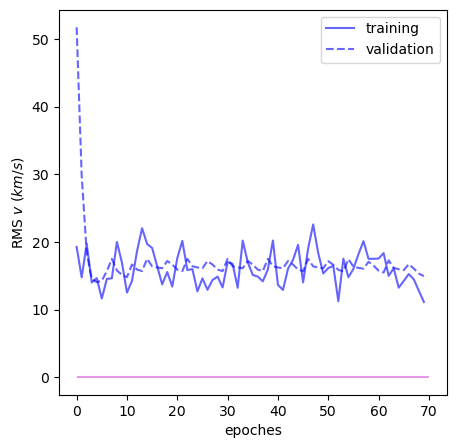

In [5]:
fig, ax = plt.subplots(1,figsize=(5,5))

plt.plot(np.sqrt(train_loss),'-b',alpha=0.6,label='training')
plt.plot(np.sqrt(valid_loss),'--b',alpha=0.6,label='validation')
# plt.ylim(0,50)
plt.legend()
ax.set_ylabel('RMS $v$ ($km/s$)')
ax.set_xlabel('epoches')
plt.hlines(1e-3,0,len(train_loss),'m',alpha=0.4)
# plt.yscale('log')
plt.savefig('/scratch/mdd423/CNN_EPRV/loss_multi_ep70.png')
plt.show()

In [6]:
s_c  = 165
s_in = 43264
s_h  = 64
s_out= 64
device = 'cpu'
model  = RV_Model(s_c,s_in,s_h,device).to(device)

In [7]:
modelname = '/scratch/mdd423/CNN_EPRV/models/rv_model_multi_51Peg_720-976_1200-1456_69_70_bcs.model'
model.load_state_dict(torch.load(modelname,map_location=torch.device('cpu')))
model.eval()

RV_Model(
  (chunk_models): ModuleList(
    (0): ChunkNet(
      (dense1): Sequential(
        (0): Linear(in_features=43264, out_features=64, bias=True)
        (1): ReLU()
      )
      (final): Linear(in_features=64, out_features=1, bias=True)
    )
    (1): ChunkNet(
      (dense1): Sequential(
        (0): Linear(in_features=43264, out_features=64, bias=True)
        (1): ReLU()
      )
      (final): Linear(in_features=64, out_features=1, bias=True)
    )
    (2): ChunkNet(
      (dense1): Sequential(
        (0): Linear(in_features=43264, out_features=64, bias=True)
        (1): ReLU()
      )
      (final): Linear(in_features=64, out_features=1, bias=True)
    )
    (3): ChunkNet(
      (dense1): Sequential(
        (0): Linear(in_features=43264, out_features=64, bias=True)
        (1): ReLU()
      )
      (final): Linear(in_features=64, out_features=1, bias=True)
    )
    (4): ChunkNet(
      (dense1): Sequential(
        (0): Linear(in_features=43264, out_features=64, bias=

In [8]:
import pickle
def save(filename,model):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

def load(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        model = pickle.load(input)
        return model

In [9]:
all_directories = glob.glob('/scratch/mdd423/CNN_EPRV/data/peg51_256/raw/peg51_256/*02-28*')
files = []
for indiv in all_directories:
    files += glob.glob(indiv + '/*.h5')

location = coords.EarthLocation.of_site('La Silla Observatory')
target   = coords.SkyCoord.from_name('51PEG')

iterations = 0
img_stack = np.empty((0,3,256,256))
rvs_stack = np.empty((0))
bcs_stack = np.empty((0))
tim_stack = np.empty((0))
ind_stack = np.empty((0))

start_time = time.time()
total = 2*len(files)

address = []
for i,filename in enumerate(files):
    for j,hdu in enumerate(['hdu_1','hdu_2']):
#     filename             = files1[0]

#         ds                   = h5.File(filename,'r')
#         img_stack, rvs_stack, bcs_stack, tim_stack = h5_to_array(ds,target,location,hdu_num=hdu)
        dir_name, tailname = path.split(filename)
        address.append(tailname + '_' + hdu)
        tailname = tailname[:-3]
        imgname = path.join(dir_name, tailname + hdu + '_img.nda')
        rvsname = path.join(dir_name, tailname + hdu + '_rvs.nda')
        bcsname = path.join(dir_name, tailname + hdu + '_bcs.nda')
        timname = path.join(dir_name, tailname + hdu + '_tim.nda')
        
        img_stack = np.append(img_stack, load(imgname),axis=0)
        rvs_stack = np.append(rvs_stack, load(rvsname),axis=0)
        bcs_stack = np.append(bcs_stack, load(bcsname),axis=0)
        tim_stack = np.append(tim_stack, load(timname),axis=0)
        
        ind_stack = np.append(ind_stack, iterations*np.ones(bcs_stack.shape,dtype=int))
        iterations += 1
        
        if (i % 5) == 0:
            load_time = time.time() - start_time
            n_batches = (i*2 + j + 1)
            load_avg  = load_time/n_batches
            remaining = (total - n_batches) * load_avg
            sys.stdout.write('\r[ Loaded: {}/{} | Avg Time: {} | Remaining: {} ]'.format(\
                                                                                       n_batches,total,
                                                                                       load_avg,
                                                                                       str(datetime.timedelta(seconds=remaining))
                                                                                      ))
    

[ Loaded: 162/166 | Avg Time: 5.833281871713238 | Remaining: 0:00:23.333127 ]]

In [10]:
ind_stack

array([  0.,   0.,   0., ..., 165., 165., 165.])

In [11]:
class ND_Dataset(Dataset):
    def __init__(self, imgs,rvs,indices):
        self.img_stack = imgs
        self.rvs_stack = rvs
        self.indices   = indices
        self.type      = torch.Tensor

    def __getitem__(self, index):
        
        return {'img': self.type(self.img_stack[index,...]).double(),
                'rvs': np.double(self.rvs_stack[index]), 
                'indices': self.indices[index]}
    
    
    def __len__(self):
        
        return len(self.rvs_stack)

In [12]:
for indunq in np.unique(ind_stack):
    dataset = ND_Dataset(img_stack[np.where(ind_stack == indunq)],bcs_stack[np.where(ind_stack == indunq)],ind_stack[np.where(ind_stack == indunq)])
    
    batch_size = 64
    n_cpu = 2
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_cpu,
    )
    for i,batch in enumerate(dataloader):
        rvhat = model(batch['img'].to(device),batch['indices']).squeeze()
        rms_rvs = np.sqrt(np.mean((rvhat.to('cpu') - batch['rvs'])**2))
        print(rms_rvs,address[indunq])
        if i > 3:
            break

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)
